<a href="https://colab.research.google.com/github/sklationd/mobilenet-v2-facemask/blob/main/CS470_PJ_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup


In [ ]:
import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
import torch
from PIL import Image
from pathlib import Path
from bs4 import BeautifulSoup
import os
import torch.nn.functional as F

# 1. Check is GPU available

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

root = '/gdrive/My Drive/CS470/Project/dataset'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 3. Define datasets

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        # self.imgs = list(sorted(os.listdir(Path(root) / 'images')))
        #self.imgs=list(sorted(os.listdir(Path(root))))

    def __getitem__(self, idx):
        folder=idx // 1000
        num= idx % 1000
        folder_name = 'data'+str(folder)
        file_list=list(sorted(os.listdir(Path(root)/folder_name)))
        file_name=file_list[num]
        img_path = os.path.join(Path(root)/folder_name,file_name)
        img=Image.open(img_path).convert("RGB")
        #print(folder_name)

        #file_name = self.img[idx]
        #img_path= os.path.join(Path(root)/'dataset/',file_name)
        #img= Image.open(img_path).convert("RGB")

        #~~~~~~.jpg                       0 ; without mask
        #00001_Mask.jpg                   1
        #00001_Mask_Chin.jpg.             2
        #00001_Mask_Mouth_Chin.jpg        3
        #00001_Mask_Nose_Mouth.jpg        4

        p_list=str(file_name).split('_')
        if len(p_list)==1:
          label=0
        elif len(p_list)==2:
          label=1
        elif len(p_list)==3:
          label=2
        elif p_list[-1]=='Chin.jpg':
          label=3
        else:
          label=4
          
        #Generate Label
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

    def __len__(self):
        return 20000


# 4. Build dataloader and transform

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = MaskDataset(preprocess)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64, shuffle=True)

In [ ]:
import cv2

print('size of train datasets :',len(train_loader.dataset))
print('size of test datasets  :',len(test_loader.dataset))

size of train datasets : 16000
size of test datasets  : 4000


# 5. Define model

In [ ]:
from torch import nn
from torch import Tensor
from typing import Callable, Any, Optional, List


__all__ = ['MobileNetV2', 'mobilenet_v2']


model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


In [ ]:
# model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model = MobileNetV2(num_classes=5)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

# 6. Training

In [ ]:
# pre-setup
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
learning_rate = 0.0005
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.000001)
loss_func = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
# for plotting
from matplotlib import pyplot as plt
train_loss_list = []
test_loss_list = []

In [ ]:
for epoch in range(num_epochs):

  epoch_loss = 0
  test_loss = 0
  best_test_loss = 1

  for i, samples in enumerate(train_loader):
      imgs, annotations = samples
      imgs, annotations = imgs.to(device), annotations.to(device)
      
      output = model(imgs)
      loss = loss_func(output,annotations)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print(f'Iteration: {i+1}/{len(train_loader)}, Loss: {loss.item()}')
      epoch_loss += loss.item()

  avg_train_loss = epoch_loss/len(train_loader)

  # Save result for plotting
  train_loss_list.append(avg_train_loss)

  # Print epoch's test loss
  print(f'Epoch {epoch} train loss: {avg_train_loss}')

  # validation
  for i,test_samples in enumerate(test_loader):
    test_imgs, test_annotations = test_samples
    test_imgs, test_annotations = test_imgs.to(device), test_annotations.to(device)

    test_output = model(test_imgs)
    loss = loss_func(test_output, test_annotations)
    test_loss += loss.item()

    # print(f'Iteration: {i+1}/{len(test_loader)}, Loss: {loss.item()}')
  
  avg_test_loss = test_loss/len(test_loader)

  # Save result for plotting
  test_loss_list.append(avg_test_loss)

  # Print epoch's test loss
  print(f'Epoch {epoch} test loss: {avg_test_loss}')
  
  # save best
  if best_test_loss > avg_test_loss:
    best_test_loss = avg_test_loss
    torch.save(model.state_dict(), Path(root) / 'best.pt')

  print('-------------------------------------')

[0.9758126680850983, 0.41526123297214507, 0.2490502351820469, 0.16624340713024138, 0.11480260559916497, 0.08713625229150057, 0.06878995877876878, 0.05646837978810072, 0.04871623854711652, 0.04254413226805627]
[0.5794232080853174, 0.28768386372498106, 0.19386532299575351, 0.12741789641597914, 0.09774567003524492, 0.07900400764294087, 0.06323327127075384, 0.057903507354831886, 0.054785524494946, 0.04476545584787216]


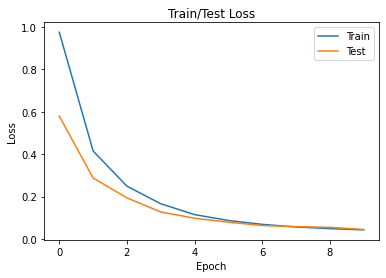

In [ ]:
# Plot
print(train_loss_list)
print(test_loss_list)

plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend(['Train', 'Test'])
plt.show()